In [1]:
import os
import platform
import numpy as np
import pandas as pd
from multiprocess import Pool, cpu_count
import plotly.express as px

from mail_helpers import ingest_emails


pd.options.mode.copy_on_write = True


Enron Email Dataset

https://www.cs.cmu.edu/~./enron/

In [2]:
# Message files end with a dot. This is not supported on Windows.
# Workaround for Windows:
# Add the prefix "\\?\" to the path to force the OS to read the files.
# normpath() is used everywhere to make sure things remain portable.
cwd = os.getcwd()
if platform.system() == "Windows":
    cwd = "\\\\?\\" + cwd
basedir = cwd + os.path.normpath("/maildir")
top_level_dirs = os.listdir(basedir)

if __name__ == "__main__":
    cpus = cpu_count()
    arglist = list(zip([basedir] * len(top_level_dirs), top_level_dirs))
    with Pool(processes=cpus) as mp_pool:
        mp_results = mp_pool.map_async(ingest_emails, arglist)
        mp_results.wait()
    all_emails = pd.concat([r for r in mp_results.get()], ignore_index=True)
    del mp_results
    del mp_pool


In [3]:
# convert float-value seconds since epoch to datetime
all_emails["Date"] = pd.to_datetime(all_emails["Date"], unit="s")
all_emails.sort_values(by="Date", inplace=True)


In [4]:
all_emails.dtypes


Top_Level_Folder            object
Mail_Folder                 object
Message_File                 int64
From                        object
To                          object
Cc                          object
Bcc                         object
Date                datetime64[ns]
Subject                     object
Body_Message                object
Body_Quoted                 object
dtype: object

In [5]:
all_emails


,Top_Level_Folder,Mail_Folder,Message_File,From,To,Cc,Bcc,Date,Subject,Body_Message,Body_Quoted
123191,germany-c,all_documents,1114,['chris.germany@enron.com'],"['doug.kinney@enron.com', 'brian.perrone@enron...",[],[],1980-01-01 00:00:00,Changes to CES deals,Here are some changes I made to the July deals...,
395291,sanders-r,all_documents,855,['richard.sanders@enron.com'],['greg.johnston@enron.com'],"['richard.sanders@enron.com', 'cyntia.distefan...","['richard.sanders@enron.com', 'cyntia.distefan...",1980-01-01 00:00:00,Re: Fort James Canada,The litigation against Ft. James has been sett...,
245362,kean-s,discussion_threads,1789,['steven.kean@enron.com'],[],[],[],1980-01-01 00:00:00,california energy prices,Summary of what we discussed the other night:\...,
245180,kean-s,discussion_threads,1620,['steven.kean@enron.com'],[],[],[],1980-01-01 00:00:00,,Attached are FERC reports\n\n\n,
502082,whalley-l,discussion_threads,257,['greg.whalley@enron.com'],['jeffrey.shankman@enron.com'],[],[],1980-01-01 00:00:00,Re:,he's a trip,
...,...,...,...,...,...,...,...,...,...,...,...
508375,williams-j,deleted_items,578,['pse6yl706@aloha.net'],[],[],[],2024-05-26 10:49:57,(None),<html>\n<head>\n<title>Untitled Document</titl...,
517045,zufferli-j,inbox/quotes,41,['cramer@cadvision.com'],"['linsider.jed@enron.com', 'john.zufferli@enro...",[],[],2043-12-28 19:34:12,marks.xls,\nHappy New Year !\n - marks.xls,
517042,zufferli-j,inbox/quotes,38,['cramer@cadvision.com'],['john.zufferli@enron.com'],[],[],2044-01-02 23:46:00,trades jan 2002,\nfeb dec trades 37.5 \nfeb dec LL went out 20...,
517040,zufferli-j,inbox/quotes,35,['cramer@cadvision.com'],['john.zufferli@enron.com'],[],[],2044-01-04 16:59:46,Trades,"\nBOM 5th to 31st traded 34, 33.5 , 33.5 and ...",


The original message body is split in two parts:

**Body_Message** is the actual message (perhaps reply) sent, without the quoted previous message.

**Body_Quoted** is the previous message (if any) quoted in the current message.

---

Remove datetime outliers

Only keep Oct 1998 - Jul 2002


In [6]:
all_emails = all_emails.query("Date >= '1998-10-01' and Date <= '2002-07-31'")


Check for empty messages

In [7]:
all_emails[all_emails["Body_Message"].str.len() == 0].shape[0]


0

Check for empty message quotes

These are messages that do not contain any previous messages quoted

They are likely thread start messages, as opposed to replies to other messages


In [8]:
all_emails[all_emails["Body_Quoted"].str.len() == 0].shape[0]


436296

Maximum subject length

In [9]:
all_emails["Subject"].str.len().max()


258

Count of messages with zero-length subject

In [10]:
all_emails[all_emails["Subject"].str.len() == 0].shape[0]


19107

Timeline distribution

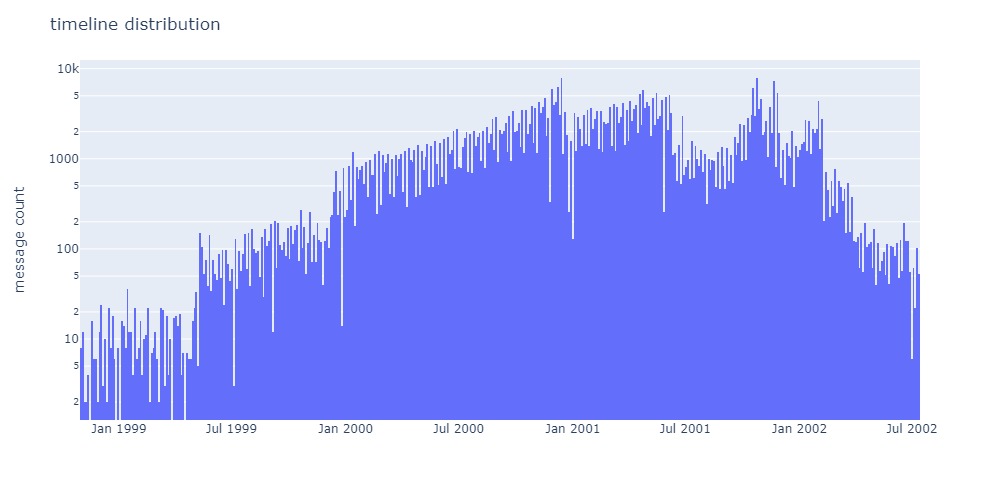

In [11]:
px.histogram(data_frame=all_emails["Date"], log_y=True).update_layout(
    title_text="timeline distribution",
    width=1000,
    height=500,
    showlegend=False,
    xaxis_title=None,
    yaxis_title="message count",
).show("png")


Message size distribution

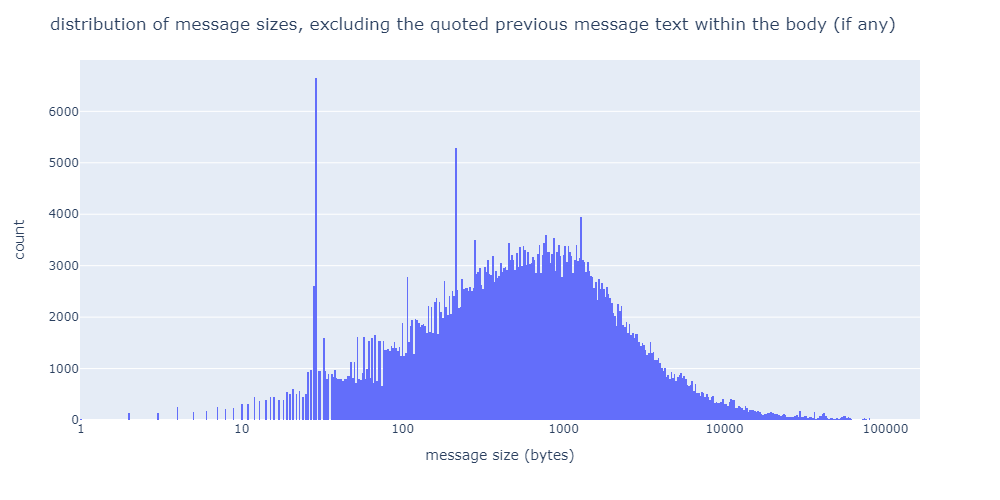

In [12]:
# px.histogram(..., log_x=True) doesn't work, this is a workaround
bm_len_max_exp = int(np.log10(all_emails["Body_Message"].str.len().max())) + 1
bm_len_tick_list = list(range(bm_len_max_exp))
bm_len_tick_text = np.power(10, bm_len_tick_list)

px.histogram(
    data_frame=np.log10(all_emails["Body_Message"].str.len().to_numpy())
).update_layout(
    title_text="distribution of message sizes, excluding the quoted previous message text within the body (if any)",
    width=1000,
    height=500,
    showlegend=False,
    xaxis_title="message size (bytes)",
    xaxis_tickvals=bm_len_tick_list,
    xaxis_ticktext=bm_len_tick_text,
    yaxis_title="count",
).show(
    "png"
)


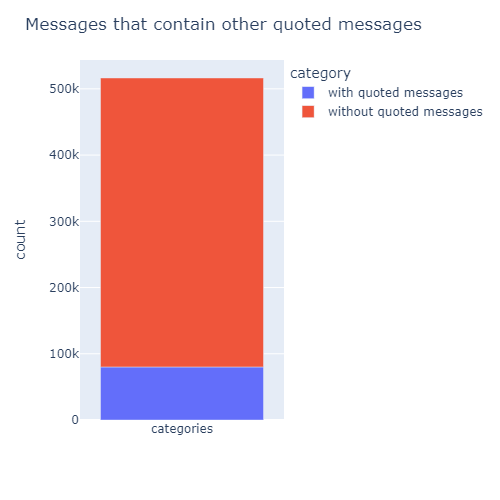

In [13]:
quote_len_cat = {
    "category": ["with quoted messages", "without quoted messages"],
    "count": [
        all_emails[all_emails["Body_Quoted"].str.len() > 0].shape[0],
        all_emails[all_emails["Body_Quoted"].str.len() == 0].shape[0],
    ],
    "x": "categories",
}

px.bar(data_frame=quote_len_cat, x="x", color="category", y="count").update_layout(
    title_text="Messages that contain other quoted messages",
    width=500,
    height=500,
    xaxis_title=None,
).show("png")


Subject length distribution

C:\Users\flori\AppData\Local\Temp\ipykernel_8264\3920718999.py:7: RuntimeWarning:

divide by zero encountered in log10



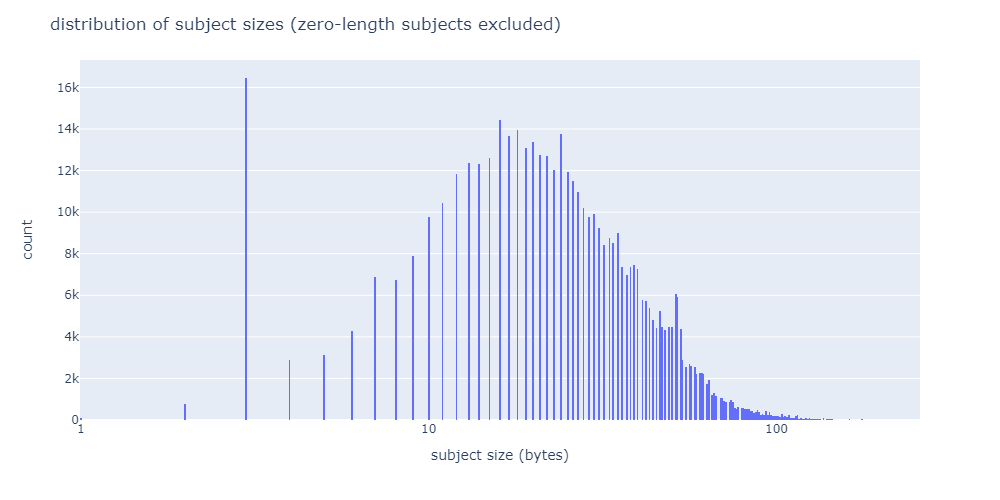

In [14]:
# px.histogram(..., log_x=True) doesn't work, this is a workaround
s_len_max_exp = int(np.log10(all_emails["Subject"].str.len().max())) + 1
s_len_tick_list = list(range(s_len_max_exp))
s_len_tick_text = np.power(10, s_len_tick_list)

px.histogram(
    data_frame=np.log10(all_emails["Subject"].str.len().to_numpy())
).update_layout(
    title_text="distribution of subject sizes (zero-length subjects excluded)",
    width=1000,
    height=500,
    showlegend=False,
    xaxis_title="subject size (bytes)",
    xaxis_tickvals=s_len_tick_list,
    xaxis_ticktext=s_len_tick_text,
    yaxis_title="count",
).show(
    "png"
)


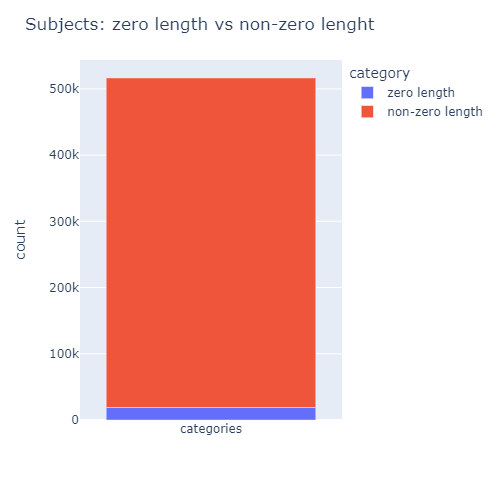

In [15]:
subj_len_cat = {
    "category": ["zero length", "non-zero length"],
    "count": [
        all_emails[all_emails["Subject"].str.len() == 0].shape[0],
        all_emails[all_emails["Subject"].str.len() > 0].shape[0],
    ],
    "x": "categories",
}

px.bar(data_frame=subj_len_cat, x="x", color="category", y="count").update_layout(
    title_text="Subjects: zero length vs non-zero lenght",
    width=500,
    height=500,
    xaxis_title=None,
).show("png")


Check for any null values

In [16]:
all_emails.isnull().sum()


Top_Level_Folder    0
Mail_Folder         0
Message_File        0
From                0
To                  0
Cc                  0
Bcc                 0
Date                0
Subject             0
Body_Message        0
Body_Quoted         0
dtype: int64

Final message count

In [17]:
all_emails.shape[0]


516345

Save to file

In [18]:
all_emails.reset_index(inplace=True, drop=True)
if os.path.exists("all_emails.csv"):
    os.remove("all_emails.csv")
all_emails.to_csv("all_emails.csv", index=True)
